In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evaluation import n_precision_at_recall_for_query, precision_at_recall_for_query, tnr_at_recall_for_query, \
    find_last_relevant_for_query, average_precision_for_query

%matplotlib inline

In [2]:
runs = pickle.load(open('../data/0_external/runs.pkl', 'rb'))

In [3]:
# remove "pubmedbert"
runs = {k: v for k, v in runs.items() if not k.startswith("pubmedbert")}

In [4]:
print(f"runs: {len(runs)}")
print(f"topics: {len(runs['bm25_abstract'])}")

runs: 20
topics: 100


In [5]:
qrels = pickle.load(open('../data/0_external/qrels.pkl', 'rb'))

In [6]:
df = pd.DataFrame()
for run_name, run in runs.items():
    scores_dict = {}
    print(run_name)
    for query_id, rankings in run.items():
        if len(rankings) != len(qrels[query_id]):
            # add missing documents at the end of the ranking with score -1000
            for doc_id in qrels[query_id].keys():
                if doc_id not in rankings:
                    rankings[doc_id] = -1000
                    
            # remove documents that are not in qrels
            rankings = {k: v for k, v in rankings.items() if k in qrels[query_id]}
        
        
        scores_dict[query_id] = {}
        # breakpoint()       
        scores_dict[query_id]['model'] = run_name
        qrels_for_query = qrels[query_id]
        scores_dict[query_id]['nP@95%'] = n_precision_at_recall_for_query(rankings=rankings, qrels=qrels_for_query,
                                                                          recall_level=0.95)
        scores_dict[query_id]['P@95%'] = precision_at_recall_for_query(rankings=rankings, qrels=qrels_for_query,
                                                                       recall_level=0.95)
        scores_dict[query_id]['TNR@95%'] = tnr_at_recall_for_query(rankings=rankings, qrels=qrels_for_query,
                                                                   recall_level=0.95)
        scores_dict[query_id]['last_rel'] = find_last_relevant_for_query(rankings=rankings, qrels=qrels_for_query)
        scores_dict[query_id]['MAP'] = average_precision_for_query(rankings=rankings, qrels=qrels_for_query)

        scores_dict[query_id]['Dataset size'] = len(rankings)
        scores_dict[query_id]['qrels_len'] = len(qrels_for_query)
        scores_dict[query_id]['%Irrelevant'] = list(qrels_for_query.values()).count(0) / len(qrels_for_query)
        scores_dict[query_id]['%Relevant'] = list(qrels_for_query.values()).count(1) / len(qrels_for_query)
    print(len(df))
    df = pd.concat([df, pd.DataFrame(scores_dict).T])

bm25_abstract
0
bm25_title
100
bm25_query
200
bm25_criteria
300
tf-idf_abstract
400
tf-idf_title
500
tf-idf_query
600
tf-idf_criteria
700
MiniLM-256_abstract
800
MiniLM-256_title
900
MiniLM-256_query
1000
MiniLM-256_criteria
1100
mpnet_abstract
1200
mpnet_title
1300
mpnet_query
1400
mpnet_criteria
1500
S-BioBert_abstract
1600
S-BioBert_title
1700
S-BioBert_query
1800
S-BioBert_criteria
1900


In [7]:
df.reset_index(names=['review_id']).groupby('review_id')[['Dataset size','qrels_len']].value_counts()

review_id  Dataset size  qrels_len
CD000009   33            33           20
CD000014   19            19           20
CD000031   199           199          20
CD000384   29            29           20
CD001150   39            39           20
                                      ..
CD012342   2353          2353         20
CD012599   8048          8048         20
CD012661   3367          3367         20
CD012669   1260          1260         20
CD012768   131           131          20
Name: count, Length: 100, dtype: int64

In [8]:
df[df['nP@95%'].isna()]

,model,nP@95%,P@95%,TNR@95%,last_rel,MAP,Dataset size,qrels_len,%Irrelevant,%Relevant


In [9]:
# drop NA for ["nP@95%"]
df = df.dropna(subset="nP@95%")
len(df)

2000

In [10]:
average_tnr = df.groupby("model")["TNR@95%"].mean().mean()
average_np = df.groupby("model")["nP@95%"].mean().mean()
average_p = df.groupby("model")["P@95%"].mean().mean()
average_last_rel = df.groupby("model")["last_rel"].mean().mean()
average_map = df.groupby("model")["MAP"].mean().mean()

# Correlation Analysis between nP@95% and other metrics

In [12]:
print(df[['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', "MAP", 'Dataset size', '%Irrelevant', '%Relevant']].corr(
    "spearman").round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & nP@95% & P@95% & TNR@95% & last_rel & MAP & Dataset size & %Irrelevant & %Relevant \\
\midrule
nP@95% & 1.000000 & 0.602000 & 0.655000 & -0.533000 & 0.570000 & -0.299000 & -0.132000 & 0.132000 \\
P@95% & 0.602000 & 1.000000 & -0.027000 & 0.140000 & 0.910000 & -0.724000 & -0.736000 & 0.736000 \\
TNR@95% & 0.655000 & -0.027000 & 1.000000 & -0.923000 & 0.014000 & 0.273000 & 0.570000 & -0.570000 \\
last_rel & -0.533000 & 0.140000 & -0.923000 & 1.000000 & 0.097000 & -0.249000 & -0.652000 & 0.652000 \\
MAP & 0.570000 & 0.910000 & 0.014000 & 0.097000 & 1.000000 & -0.637000 & -0.639000 & 0.639000 \\
Dataset size & -0.299000 & -0.724000 & 0.273000 & -0.249000 & -0.637000 & 1.000000 & 0.769000 & -0.769000 \\
%Irrelevant & -0.132000 & -0.736000 & 0.570000 & -0.652000 & -0.639000 & 0.769000 & 1.000000 & -1.000000 \\
%Relevant & 0.132000 & 0.736000 & -0.570000 & 0.652000 & 0.639000 & -0.769000 & -1.000000 & 1.000000 \\
\bottomrule
\end{tabular}


In [13]:
sns.set_theme(style="whitegrid")

# Plot of nP@95% vs TNR@95%

In [14]:
def plot_two_metrics(data: pd.DataFrame, metric1_column, metric2_column,
                     metric1_name=None, metric2_name=None,
                     average_metric1=None, average_metric2=None) -> plt.plot:
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(8, 3.5))  # You can adjust the dimensions as needed

    min_marker_size = 35  # Minimum marker size
    max_marker_size = 140  # Maximum marker size
    data_size_normalised = (data['Dataset size'] - data['Dataset size'].min()) / (
            data['Dataset size'].max() - data['Dataset size'].min())
    marker_sizes = min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised

    marker_sizes = marker_sizes.astype(float)

    # Create the scatterplot
    ax = sns.scatterplot(
        data=data,
        x=metric1_column,
        y=metric2_column,
        hue="model",
        palette="colorblind",  # Using a colorblind-friendly palette
        style="model",  # Different marker styles for each model
        size=marker_sizes.tolist(),  # Adjust the size of the markers
        alpha=0.7  # Set transparency to avoid overplotting
    )

    # Add enhancements
    if metric1_name:
        plt.xlabel(metric1_name, fontsize=12)
    if metric2_name:
        plt.ylabel(metric2_name, fontsize=12)
    ax.legend(title="Model", loc='lower right')  # Move the legend outside the plot

    # Add reference lines if necessary set width of lines to 0.5
    if average_metric1:
        ax.axvline(x=average_np, color='gray', linestyle='--', label='Avg. nP', alpha=0.7, linewidth=1)
    if average_metric2:
        ax.axhline(y=average_metric2, color='gray', linestyle='--', label='Avg. TNR', alpha=0.7, linewidth=1)

    handles, labels = plt.gca().get_legend_handles_labels()
    # Filter out the handles and labels you don't want to show in the legend
    # This depends on how you have added your average lines and bubble sizes.
    # For example, if they are the last two handles, you can do:
    new_handles = handles[:-8]
    new_labels = labels[:-8]

    # Now create a new legend with the filtered handles and labels
    plt.legend(new_handles, new_labels, prop={'size': 6})

    # Save the figure
    plt.tight_layout()
    return plt


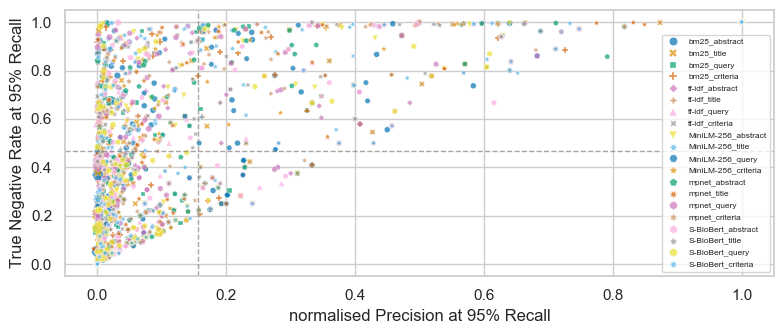

In [15]:
plt = plot_two_metrics(data=df, metric1_column="nP@95%", metric2_column="TNR@95%",
                       metric1_name='normalised Precision at 95% Recall',
                       metric2_name='True Negative Rate at 95% Recall',
                       average_metric1=average_np, average_metric2=average_tnr)
# plt.figure(figsize=(16, 8))  # You can adjust the dimensions as needed
# 
# min_marker_size = 35  # Minimum marker size
# max_marker_size = 140  # Maximum marker size
# data_size_normalised = (df['Dataset size'] - df['Dataset size'].min()) / (df['Dataset size'].max() - df['Dataset size'].min())
# marker_sizes = min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised
# 
# marker_sizes = marker_sizes.astype(float)
# 
# # Create the scatterplot
# ax = sns.scatterplot(
#     data=df,
#     x="nP@95%",
#     y="TNR@95%",
#     hue="model",
#     palette="colorblind",  # Using a colorblind-friendly palette
#     style="model",  # Different marker styles for each model
#     size=marker_sizes.tolist(),  # Adjust the size of the markers
#     alpha=0.7  # Set transparency to avoid overplotting
# )
# 
# # Add enhancements
# plt.xlabel('normalised Precision at 95% Recall', fontsize=14)
# plt.ylabel('True Negative Rate at 95% Recall', fontsize=14)
# ax.legend(title="Model", loc='lower right')  # Move the legend outside the plot
# 
# # Add reference lines if necessary set width of lines to 0.5
# ax.axhline(y=average_tnr, color='gray', linestyle='--', label='Avg. TNR', alpha=0.7, linewidth=1)
# ax.axvline(x=average_np, color='gray', linestyle='--', label='Avg. nP', alpha=0.7, linewidth=1)
# 
# # Save the figure
# plt.tight_layout()
plt.savefig("../reports/nP_at_95_vs_TNR_at_95.pdf", dpi=300)


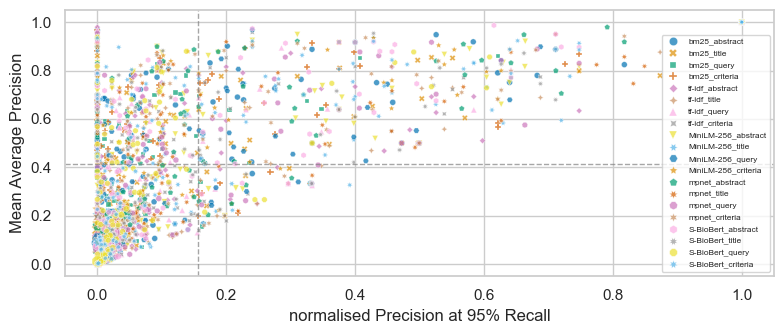

In [16]:
plt = plot_two_metrics(data=df, metric1_column="nP@95%", metric2_column="MAP",
                       metric1_name='normalised Precision at 95% Recall', metric2_name='Mean Average Precision',
                       average_metric1=average_p, average_metric2=average_map)
plt.savefig("../reports/nP_at_95_vs_MAP.pdf", dpi=300)

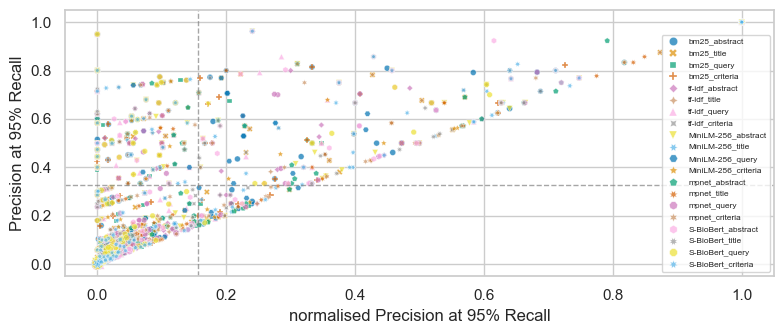

In [17]:
plt = plot_two_metrics(data=df, metric1_column="nP@95%", metric2_column="P@95%",
                       metric1_name='normalised Precision at 95% Recall', metric2_name='Precision at 95% Recall',
                       average_metric1=average_np, average_metric2=average_p)
plt.savefig("../reports/nP_at_95_vs_P_at_95.pdf", dpi=300)

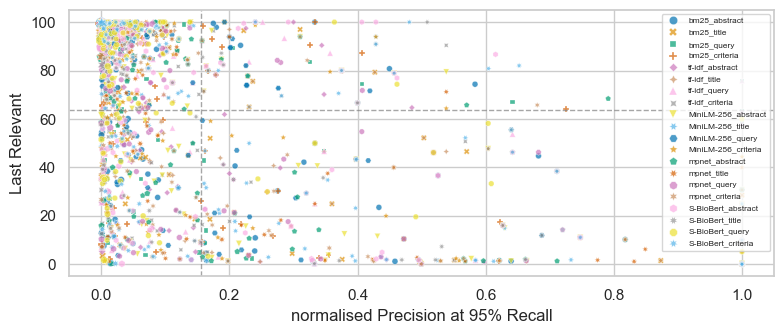

In [18]:
plt = plot_two_metrics(data=df, metric1_column="nP@95%", metric2_column="last_rel",
                       metric1_name='normalised Precision at 95% Recall', metric2_name='Last Relevant',
                       average_metric1=average_p, average_metric2=average_last_rel)

plt.savefig("../reports/nP_at_95_vs_LastRel.pdf", dpi=300)

# Bland-Altman plot

In [19]:
# plot Bland-Altman Plot: This plot can be used to assess the agreement between nP@95% and TNR@95% for each model. It will help to visualize the extent of disagreement (bias) and the pattern of this disagreement across the range of measurements.

def bland_altman_plot(data1, data2, labels, data_sizes, *args, **kwargs):
    """
    Bland-Altman Plot.
    
    A Bland-Altman plot is a graphical method to analyze the differences 
    between two methods of measurement. The mean of the measures is plotted 
    against their difference.

    Parameters:
    - data1, data2: Arrays of the two sets of measurements to be compared.
    - labels : list Labels of the two sets of measurements. E.g. model name
    """
    min_marker_size = 35  # Minimum marker size
    max_marker_size = 140  # Maximum marker size
    data_size_normalised = (data_sizes - data_sizes.min()) / (data_sizes.max() - data_sizes.min())
    marker_sizes = min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised

    data1 = np.asarray(data1)
    data2 = np.asarray(data2)

    # Calculate means and differences
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    # Create plot
    plt.figure(figsize=(8, 5))

    # color items by labels. labels is a list of strings with the same length as data1 and data2
    sns.scatterplot(x=mean, y=diff, *args, **kwargs, hue=labels, style=labels, palette="colorblind",
                    size=marker_sizes, alpha=0.7)

    plt.axhline(md, color='cadetblue', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axhline(md + 1.96 * sd, color='salmon', linestyle='--', alpha=0.7, linewidth=1)
    plt.axhline(md - 1.96 * sd, color='salmon', linestyle='--', alpha=0.7, linewidth=1)

    plt.text(mean.max(), md, 'Mean', va='bottom', ha='right', color='cadetblue', alpha=0.7)
    plt.text(mean.max(), md + 1.96 * sd, '+1.96 SD', va='bottom', ha='right', color='salmon', alpha=0.7)
    plt.text(mean.max(), md - 1.96 * sd, '-1.96 SD', va='bottom', ha='right', color='salmon', alpha=0.7)

    # add legend
    # handles, _ = ax.get_legend_handles_labels()
    # ax.legend(handles, labels)

    plt.xlabel('Mean of Two Measures', fontsize=14)
    plt.ylabel('Difference Between Two Measures', fontsize=14)

    # turn off legend
    plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.savefig("../reports/np_tnr_bland_altman_plot.pdf", dpi=300)

# Example usage
# data1 = [your_data_set_1]
# data2 = [your_data_set_2]
# bland_altman_plot(data1, data2)

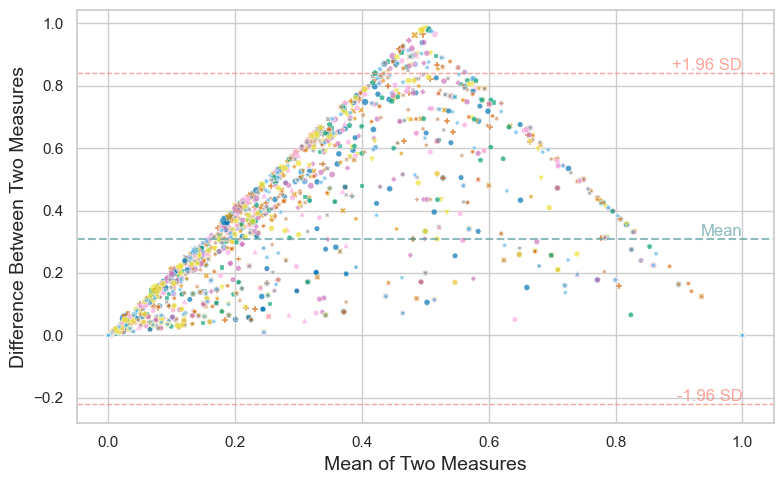

In [20]:
bland_altman_plot(df["TNR@95%"], df["nP@95%"], labels=df["model"].tolist(),
                  data_sizes=df["Dataset size"])

# Average score by model and ranking

In [21]:
import pandas as pd
from scipy import stats

In [22]:
df['last_rel'] = 100 - df['last_rel']

In [23]:
df.groupby('model').mean()[['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', 'MAP']]

,nP@95%,P@95%,TNR@95%,last_rel,MAP
model,,,,,
MiniLM-256_abstract,0.188969,0.361128,0.522238,40.725268,0.468661
MiniLM-256_criteria,0.194083,0.355473,0.52102,39.933115,0.455862
MiniLM-256_query,0.12536,0.300058,0.445975,34.957807,0.355457
MiniLM-256_title,0.173572,0.346803,0.495749,37.725864,0.430589
S-BioBert_abstract,0.16283,0.327334,0.491593,36.722407,0.448182
S-BioBert_criteria,0.177001,0.342862,0.498789,37.931754,0.467955
S-BioBert_query,0.096342,0.275034,0.365511,27.567613,0.334608
S-BioBert_title,0.138294,0.319808,0.437146,34.040752,0.368937
bm25_abstract,0.168285,0.341329,0.473703,36.808811,0.45558


In [24]:
df.groupby('model').mean()[['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', 'MAP']].rank(ascending=False, method='min')

,nP@95%,P@95%,TNR@95%,last_rel,MAP
model,,,,,
MiniLM-256_abstract,4.0,4.0,3.0,4.0,3.0
MiniLM-256_criteria,3.0,5.0,4.0,5.0,5.0
MiniLM-256_query,17.0,17.0,13.0,12.0,16.0
MiniLM-256_title,7.0,6.0,7.0,8.0,9.0
S-BioBert_abstract,9.0,10.0,8.0,11.0,7.0
S-BioBert_criteria,6.0,7.0,6.0,6.0,4.0
S-BioBert_query,20.0,19.0,20.0,20.0,19.0
S-BioBert_title,15.0,14.0,15.0,15.0,15.0
bm25_abstract,8.0,8.0,11.0,10.0,6.0


In [25]:
print(df.groupby('model').mean()[['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', 'MAP']].rank(ascending=False, method='min').sort_values(
    'nP@95%').astype(int).to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & nP@95% & P@95% & TNR@95% & last_rel & MAP \\
model &  &  &  &  &  \\
\midrule
mpnet_abstract & 1 & 1 & 1 & 1 & 1 \\
mpnet_criteria & 2 & 2 & 2 & 2 & 2 \\
MiniLM-256_criteria & 3 & 5 & 4 & 5 & 5 \\
MiniLM-256_abstract & 4 & 4 & 3 & 4 & 3 \\
mpnet_title & 5 & 3 & 5 & 3 & 8 \\
S-BioBert_criteria & 6 & 7 & 6 & 6 & 4 \\
MiniLM-256_title & 7 & 6 & 7 & 8 & 9 \\
bm25_abstract & 8 & 8 & 11 & 10 & 6 \\
S-BioBert_abstract & 9 & 10 & 8 & 11 & 7 \\
bm25_title & 10 & 9 & 12 & 13 & 11 \\
tf-idf_abstract & 11 & 11 & 9 & 9 & 12 \\
bm25_criteria & 12 & 13 & 17 & 17 & 10 \\
mpnet_query & 13 & 12 & 10 & 7 & 13 \\
tf-idf_title & 14 & 15 & 16 & 16 & 18 \\
S-BioBert_title & 15 & 14 & 15 & 15 & 15 \\
tf-idf_criteria & 16 & 16 & 14 & 14 & 14 \\
MiniLM-256_query & 17 & 17 & 13 & 12 & 16 \\
bm25_query & 18 & 18 & 18 & 18 & 17 \\
tf-idf_query & 19 & 20 & 19 & 19 & 20 \\
S-BioBert_query & 20 & 19 & 20 & 20 & 19 \\
\bottomrule
\end{tabular}


In [26]:
df.fillna(0, inplace=True)

In [32]:
metrics = ['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', 'MAP']
for metric in metrics:
    df[metric] = df[metric].astype(float)

In [33]:
models = df['model'].unique()
# models = ['mpnet_criteria', 'mpnet_abstract', 'MiniLM-256_criteria', 'MiniLM-256_abstract', 'mpnet_title']
print(models)

n_comparisons = len(models) * (len(models) - 1) / 2
p_value = 0.05 / n_comparisons
print(f"p_value: {p_value}")


for m1_index, model1 in enumerate(models):
    if model1 != 'mpnet_criteria':
        continue
    for m2_index, model2 in enumerate(models):
        # if m1_index >= m2_index:
        #     continue
        print(f"{model1} vs {model2}")
        print(stats.ttest_rel(df[df['model'] == model1]['nP@95%'], df[df['model'] == model2]['nP@95%']))
        print(stats.ttest_rel(df[df['model'] == model1]['P@95%'], df[df['model'] == model2]['P@95%']))
        print(stats.ttest_rel(df[df['model'] == model1]['TNR@95%'], df[df['model'] == model2]['TNR@95%']))
        print(stats.ttest_rel(df[df['model'] == model1]['last_rel'], df[df['model'] == model2]['last_rel']))
        print(stats.ttest_rel(df[df['model'] == model1]['MAP'], df[df['model'] == model2]['MAP']))
        print()

['bm25_abstract' 'bm25_title' 'bm25_query' 'bm25_criteria'
 'tf-idf_abstract' 'tf-idf_title' 'tf-idf_query' 'tf-idf_criteria'
 'MiniLM-256_abstract' 'MiniLM-256_title' 'MiniLM-256_query'
 'MiniLM-256_criteria' 'mpnet_abstract' 'mpnet_title' 'mpnet_query'
 'mpnet_criteria' 'S-BioBert_abstract' 'S-BioBert_title' 'S-BioBert_query'
 'S-BioBert_criteria']
p_value: 0.0002631578947368421
mpnet_criteria vs bm25_abstract
TtestResult(statistic=2.109349608808294, pvalue=0.03743688659169654, df=99)
TtestResult(statistic=2.192999255389206, pvalue=0.030648923028650552, df=99)
TtestResult(statistic=2.503742888233925, pvalue=0.013923673719904927, df=99)
TtestResult(statistic=2.9190727536740826, pvalue=0.004346295663895301, df=99)
TtestResult(statistic=2.1061080357823134, pvalue=0.037724232337900905, df=99)

mpnet_criteria vs bm25_title
TtestResult(statistic=2.3050555857591375, pvalue=0.02325111239230115, df=99)
TtestResult(statistic=2.566133537002564, pvalue=0.01178224914582378, df=99)
TtestResult(sta

In [34]:
models = df['model'].unique()
# models = ['mpnet_criteria', 'mpnet_abstract', 'MiniLM-256_criteria', 'MiniLM-256_abstract', 'mpnet_title']
print(models)

n_comparisons = len(models) * (len(models) - 1) / 2
p_value = 0.05 / n_comparisons
print(f"p_value: {p_value}")


for m1_index, model1 in enumerate(models):
    if model1 != 'mpnet_criteria':
        continue
    for m2_index, model2 in enumerate(models):
        # if m1_index >= m2_index:
        #     continue
        print(f"{model1} vs {model2}")
        print(stats.ttest_ind(df[df['model'] == model1]['nP@95%'], df[df['model'] == model2]['nP@95%'], equal_var=False))
        print(stats.ttest_ind(df[df['model'] == model1]['P@95%'], df[df['model'] == model2]['P@95%'], equal_var=False))
        print(stats.ttest_ind(df[df['model'] == model1]['TNR@95%'], df[df['model'] == model2]['TNR@95%'], equal_var=False))
        print(stats.ttest_ind(df[df['model'] == model1]['last_rel'], df[df['model'] == model2]['last_rel'], equal_var=False))
        print(stats.ttest_ind(df[df['model'] == model1]['MAP'], df[df['model'] == model2]['MAP'], equal_var=False))
        print()

['bm25_abstract' 'bm25_title' 'bm25_query' 'bm25_criteria'
 'tf-idf_abstract' 'tf-idf_title' 'tf-idf_query' 'tf-idf_criteria'
 'MiniLM-256_abstract' 'MiniLM-256_title' 'MiniLM-256_query'
 'MiniLM-256_criteria' 'mpnet_abstract' 'mpnet_title' 'mpnet_query'
 'mpnet_criteria' 'S-BioBert_abstract' 'S-BioBert_title' 'S-BioBert_query'
 'S-BioBert_criteria']
p_value: 0.0002631578947368421
mpnet_criteria vs bm25_abstract
TtestResult(statistic=1.0528483230644659, pvalue=0.293703534322239, df=196.4876804690375)
TtestResult(statistic=0.75948813737468, pvalue=0.44846390678418124, df=197.99442674405407)
TtestResult(statistic=1.25278439977006, pvalue=0.21176224583477513, df=197.93051429643896)
TtestResult(statistic=1.2394270417561377, pvalue=0.2166552786465749, df=197.88919703957023)
TtestResult(statistic=0.7453712807093706, pvalue=0.45693189685484137, df=197.84244166658968)

mpnet_criteria vs bm25_title
TtestResult(statistic=1.517237163440552, pvalue=0.13088064595916268, df=188.663172245721)
TtestRe

# calculate the discriminative power

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [36]:
significant_pairs_count = {}

# Perform Tukey HSD test for each metric and count significantly different pairs
for metric in metrics:
    tukey = pairwise_tukeyhsd(endog=df[metric], groups=df['model'], alpha=0.05)
    # Count number of significantly different pairs
    significant_pairs_count[metric] = np.sum(tukey.reject)

In [37]:
significant_pairs_count

{'nP@95%': 0, 'P@95%': 0, 'TNR@95%': 3, 'last_rel': 0, 'MAP': 8}

In [38]:
unique_systems_count = df['model'].nunique()
total_system_pairs = (unique_systems_count * (unique_systems_count - 1)) // 2
total_system_pairs

190

# Impact of different recall levels

In [39]:
levels_df = pd.DataFrame()
for run_name, run in runs.items():
    scores_dict = {}
    print(run_name)
    for query_id, rankings in run.items():
        scores_dict[query_id] = {}
        scores_dict[query_id]['model'] = run_name
        qrels_for_query = qrels[query_id]

        for recall_level_index in range(50, 101, 1):
            recall_level = recall_level_index / 100.0

            scores_dict[query_id][f'nP@{recall_level_index}%'] = n_precision_at_recall_for_query(rankings=rankings,
                                                                                                 qrels=qrels_for_query,
                                                                                                 recall_level=recall_level)
            scores_dict[query_id][f'P@{recall_level_index}%'] = precision_at_recall_for_query(rankings=rankings,
                                                                                              qrels=qrels_for_query,
                                                                                              recall_level=recall_level)
            scores_dict[query_id][f'TNR@{recall_level_index}%'] = tnr_at_recall_for_query(rankings=rankings,
                                                                                          qrels=qrels_for_query,
                                                                                          recall_level=recall_level)

        scores_dict[query_id]['Dataset size'] = len(rankings)
        scores_dict[query_id]['%Irrelevant'] = list(qrels_for_query.values()).count(0) / len(qrels_for_query)
        scores_dict[query_id]['%Relevant'] = list(qrels_for_query.values()).count(1) / len(qrels_for_query)
    print(len(levels_df))
    levels_df = pd.concat([levels_df, pd.DataFrame(scores_dict).T])

bm25_abstract
0
bm25_title
100
bm25_query
200
bm25_criteria
300
tf-idf_abstract
400
tf-idf_title
500
tf-idf_query
600
tf-idf_criteria
700
MiniLM-256_abstract
800
MiniLM-256_title
900
MiniLM-256_query
1000
MiniLM-256_criteria
1100
mpnet_abstract
1200
mpnet_title
1300
mpnet_query
1400
mpnet_criteria
1500
S-BioBert_abstract
1600
S-BioBert_title
1700
S-BioBert_query
1800
S-BioBert_criteria
1900


In [40]:
levels_means_df = levels_df.groupby('model')[levels_df.columns[1:-3]].mean().stack().reset_index()
levels_means_df = levels_means_df.rename(columns={0: 'Score'})

In [41]:
levels_means_df['Measure'] = levels_means_df['level_1'].str.split('@').str[0]
levels_means_df['Recall'] = levels_means_df['level_1'].str.split('@').str[1].str[:-1]
levels_means_df['Recall'] = levels_means_df['Recall'].astype(int)
levels_means_df.drop(columns=['level_1'], inplace=True)

In [42]:
levels_means_df.head()

,model,Score,Measure,Recall
0,MiniLM-256_abstract,0.396648,nP,50
1,MiniLM-256_abstract,0.473631,P,50
2,MiniLM-256_abstract,0.822684,TNR,50
3,MiniLM-256_abstract,0.372793,nP,51
4,MiniLM-256_abstract,0.459294,P,51


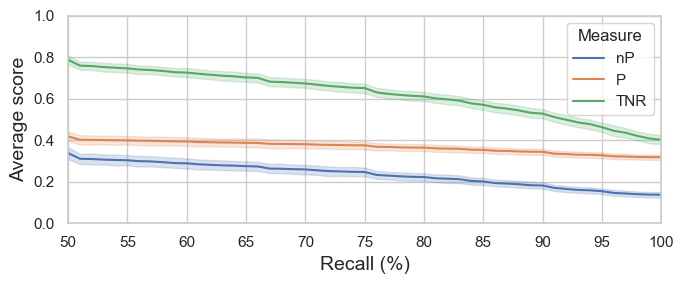

In [43]:
plt.figure(figsize=(7, 3))

sns.set_theme(style="whitegrid")

sns.lineplot(levels_means_df,
             x='Recall',
             y='Score',
             hue='Measure')

plt.xticks(np.arange(levels_means_df['Recall'].min(), levels_means_df['Recall'].max() + 1, 5.0))

# min and max y axis from 0 to 1
plt.ylim(0, 1)
plt.xlim(levels_means_df['Recall'].min(), levels_means_df['Recall'].max())

plt.xlabel('Recall (%)', fontsize=14)
plt.ylabel('Average score', fontsize=14)

plt.tight_layout()
plt.savefig("../reports/impact_of_recall.pdf", dpi=300)